In [1]:
import numpy as np
import soundfile as sf
import os
import re
import pandas as pd
from IPython.display import clear_output
import librosa
import pickle
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Klasyfikacja wielostanowa przy użyciu modelu GMM.

Celem raportu jest stworzenie modeli zdolnych do rozpoznawania ludzi na podstawie ich nagrań.

### Przygotowanie danych.

In [2]:
#Ścieżka do pliku tekstowego, w którym znajdują się informacje o mówcach
file_path = 'C:/Users/zbugo/Desktop/praktyki_zadania/8/train-clean-100/LibriSpeech/SPEAKERS.TXT'

#Tworzę ramkę danych, w której znajdują się informacje o płci danego mówcy
df = pd.read_csv(file_path, sep='|', comment=';', usecols=[0, 1], 
                 names=["ID", "SEX"])



#Ścieżka do folderu, w którym znajdują się katalogi z nagraniami osób
file_path = 'C:/Users/zbugo/Desktop/praktyki_zadania/8/train-clean-100/LibriSpeech/train-clean-100/'

#Wyciągam wszystkie nazwy podfolderów z powyższej ścieżki (są to ID nagranych osób)
subfolders = [f.name for f in os.scandir(file_path) if f.is_dir()]

#Sortuję ID nagranych osób (najpierw muszę zamienić ID na liczbę)
subfolders = sorted([int(item) for item in subfolders])
subfolders = np.array(subfolders)

df = df.loc[np.isin(np.array(df['ID']), subfolders)]

#Tworzę oddzielne ramki dla kobiet i mężczyzn
df_woman = df[df['SEX'] == ' F '].reset_index(drop=True)
df_man = df[df['SEX'] == ' M '].reset_index(drop=True)

In [3]:
df_man.head()

,ID,SEX
0,26,M
1,27,M
2,60,M
3,78,M
4,118,M


Ramki danych zawierają ID mówcy oraz jego płeć. Ramka danych dla kobiet wygląda analogicznie.

In [4]:
folders_path = "C:/Users/zbugo/Desktop/praktyki_zadania/8/train-clean-100/LibriSpeech/train-clean-100"
subfolders = [f.name for f in os.scandir(folders_path) if f.is_dir()]
subfolders = sorted([int(item) for item in subfolders])
subfolders = [str(item) for item in subfolders]

paths_with_ID = [folders_path + '/'+ subfolder for subfolder in subfolders]

data_frame_for_duration_woman = pd.DataFrame(columns=['ID', 'duration'])
data_frame_for_duration_man = pd.DataFrame(columns=['ID', 'duration'])

for path_with_ID in paths_with_ID:

    paths_inside_ID = [f.name for f in os.scandir(path_with_ID) if f.is_dir()]
    #print(paths_inside_ID)

    #sciezka
    full_paths_to_files = [path_with_ID + '/' + path_inside_ID for path_inside_ID in paths_inside_ID]
    #print(full_paths_to_files)

    all_files_for_ID = []
    for full_path_to_files in full_paths_to_files:
        files = [f.name for f in os.scandir(full_path_to_files) if f.is_file() and f.name.endswith('.flac')]
        files = [full_path_to_files + '/' + file for file in files]
        all_files_for_ID = all_files_for_ID + files

    #print(all_files_for_ID)

    duration_in_seconds = 0
    for file_for_ID in all_files_for_ID:
        with sf.SoundFile(file_for_ID) as f:
            frames = len(f)  # Liczba próbek (frames)
            sample_rate = f.samplerate  # Częstotliwość próbkowania
        duration = frames / sample_rate
        duration_in_seconds = duration_in_seconds + duration
    

    ID = path_with_ID.split('/')[-1]
    new_record = [ID, duration_in_seconds]
    
    if np.isin(ID, df_woman['ID']):
        data_frame_for_duration_woman.loc[len(data_frame_for_duration_woman)] = new_record
    else:
        data_frame_for_duration_man.loc[len(data_frame_for_duration_man)] = new_record

    print(ID)
    clear_output(wait=True)

data_frame_for_duration_woman = data_frame_for_duration_woman.sort_values(by='duration', ascending=False)
data_frame_for_duration_man = data_frame_for_duration_man.sort_values(by='duration', ascending=False)

top_50_man = data_frame_for_duration_man.head(50)
top_50_woman = data_frame_for_duration_woman.head(50)

8975


In [5]:
top_50_man.head()

,ID,duration
56,3436,1514.735063
6,196,1514.525000
108,7447,1514.240000
20,460,1513.885000
93,6454,1513.480000


Ramka danych zawiera ID mówcy oraz zsumowaną długość wszystkich jego nagrań (50 kobiet i 50 mężczyzn z najdłuższymi zsumowanymi nagraniami). Wiersze są uporządkowane malejąco, więc na górze znajdują się osoby z największą łączną długością nagrań. Analogicznie wygląda ramka danych dla kobiet. Widać, że różnice w całkowitej długości nagrań są bardzo niewielkie, ale dotyczy to tylko osób walczących o miano mistrza w tej kategorii. Poniżej można zobaczyć ramkę przedstawiającą mężczyzn z najkrótszymi czasami zsumowanych nagraniań.

In [6]:
data_frame_for_duration_man.tail()

,ID,duration
99,6925,1024.415000
27,1034,1002.705062
28,1040,942.175062
17,445,664.915000
105,7312,326.564937


In [9]:
folders_path = "C:/Users/zbugo/Desktop/praktyki_zadania/8/train-clean-100/LibriSpeech/train-clean-100"

top_50_man_paths = [folders_path + '/' + ID for ID in top_50_man['ID']]
top_50_woman_paths = [folders_path + '/' + ID for ID in top_50_woman['ID']]

top_50_man_and_woman = top_50_man_paths + top_50_woman_paths

100

Lista zawiera ścieżki do folderów osób z najdłuższym zsumowanym czasem nagrań (50 kobiet i 50 mężczyzn).

In [10]:
def split_train_test_data(path_to_files):
    
    #teraz jestem w folderze z ID np. C:/Users/zbugo/Desktop/praktyki_zadania/8/train-clean-100/LibriSpeech/train-clean-100/19
    paths_inside_ID = [f.name for f in os.scandir(path_to_files) if f.is_dir()]

    #teraz jestem w folderze z danej osoby np. C:/Users/zbugo/Desktop/praktyki_zadania/8/train-clean-100/LibriSpeech/train-clean-100/19/198
    full_paths_to_files = [path_to_files + '/' + path_inside_ID for path_inside_ID in paths_inside_ID]
        
    
    #w pętli wyciągam wszystkie ścieżki do nagrań danej osoby czyli np.
    #C:/Users/zbugo/Desktop/praktyki_zadania/8/train-clean-100/LibriSpeech/train-clean-100/19/198/19-198-0000.flac
    #w all_files_for_ID przechowuje ścieżki do wszysktich plików danej osoby
    all_files_for_ID = []
    for full_path_to_files in full_paths_to_files:
        files = [f.name for f in os.scandir(full_path_to_files) if f.is_file() and f.name.endswith('.flac')]
        files = [full_path_to_files + '/' + file for file in files]
        all_files_for_ID = all_files_for_ID + files
        

    #wszyskie nagrania danej osoby wczytuję i łączę w jededno baaardzo długie nagranie
    sr = 16000
    combined_signals = np.array([])
    for file_for_ID in all_files_for_ID:
        signal, sr = librosa.load(file_for_ID, sr = sr)
        combined_signals = np.concatenate([combined_signals, signal])
            

    #baaardzo długie nagranie dzielę na 5 sekudnowe fragmenty, ogonek baaardzo długiego nagrania który nie łapie nie ma długości 5 sekund, po prostu wyrzucam
    list_for_5_sec_parts = []
    len_of_combined_signals = len(combined_signals)
    #ustalam 5 sekundowy skok
    step = 5*sr    
    for i in np.arange(start=0, stop=len_of_combined_signals-step, step=step):
        list_for_5_sec_parts.append(combined_signals[i:i+step].tolist())

    #losuję co ma być zestawem uczącym a testowym - które 5 sekundowe fragmenty będą w zestawie uczącym a któe w testowym
    five_second_parts = np.array(list_for_5_sec_parts)
    train_size = int(np.floor(0.8*len(five_second_parts)))
    sampled_parts = np.random.choice(range(0, len(five_second_parts)), size=train_size, replace=False)
    train_parts = five_second_parts[sampled_parts]
    rest_of_indexes = ~np.isin(range(0, len(five_second_parts)), sampled_parts)
 
    test_parts = five_second_parts[rest_of_indexes]
    train_data = np.concatenate(train_parts)


    return train_data, test_parts

Powyższa funkcja służy do podziału na zestaw treningowy i testowy. Wystarczy podać jej ścieżkę do danej osoby, a funkcja automatycznie zajmie się resztą. Wydzielam zbiór uczący i testowy dla każdej osoby, ponieważ będzie tyle modeli, ile jest osób.

In [12]:
train_data = []
test_data = []

#w pętli wykorzystuję wyżej napisaną fukncje i nagrania każdej z osób dzielę na zestaw treningowy i testowy
for i in range(0, 100):
    train, test = split_train_test_data(top_50_man_and_woman[i])
    train_data.append(train)
    test_data.append(test)

    print(i)
    clear_output(wait=True)
    

99


Lista z danymi treningowymi zawiera jednowymiarowe tablice, gdzie każda tablica odpowiada jednej osobie. Każda tablica to jedno bardzo długie nagranie, złożone z pięciosekundowych ramek pochodzących ze zbioru treningowego. Z kolei lista z danymi testowymi zawiera tablice wielowymiarowe. Na przykład w test_data[0] znajdują się pięciosekundowe nagrania testowe pierwszej osoby. Aby wyciągnąć pojedyncze nagranie, należy użyć kodu test_data[0][0], co zwróci pierwsze nagranie pierwszej osoby.

In [13]:
#Liczba współczynników, które otrzymamy po przeprowadzeniu MFCC — ta ilość współczynników powstaje w wyniku DCT (dyskretnej transformacji kosinusowej)
quantity_of_mel_coef = 13
#Liczba filtrów melowych — ilość 'czapek', które zostaną nałożone na sygnał. Dla każdego z nich będzie sumowana energia
quantity_of_mel_filters = 26

mfcc_train = []
mfcc_test = []

#w pętli liczę współczynniki MFCC dla zestawów treningowych i testowych
for i in range(0, 100):
    mfcc_signal = librosa.feature.mfcc(y=train_data[i], sr=16000, n_mfcc=quantity_of_mel_coef, n_mels = quantity_of_mel_filters).T
    mfcc_train.append(mfcc_signal)
    
    records_test_mfcc = []
    for j in range(0, len(test_data[i])):
        mfcc_signal = librosa.feature.mfcc(y=test_data[i][j], sr=16000, n_mfcc=quantity_of_mel_coef, n_mels = quantity_of_mel_filters).T
        records_test_mfcc.append(mfcc_signal)
    mfcc_test.append(records_test_mfcc)

    print(i)
    clear_output(wait=True)

99


W powyższym bloku kodu obliczam współczynniki MFCC dla nagrań z zestawu treningowego oraz testowego.

In [14]:
with open('mfcc_train.pkl', 'wb') as file:
    pickle.dump(mfcc_train, file)

with open('mfcc_test.pkl', 'wb') as file:
    pickle.dump(mfcc_test, file)

Zapisuję powyższe listy, abym zawsze mógł korzystać z tych samych zestawów. Przyspiesza to pracę z danymi (nie muszę uruchamiać funkcji dzielącej na zbiory testowe i uczące która pracuje parę minut) oraz zapewnia spójność wyników, ponieważ używam tych samych zestawów. Dzięki temu wyniki modeli są miarodajne. Gdybym za każdym razem tworzył nowe zestawy treningowe i testowe, musiałbym za każdym razem na nowo trenować modele.

In [15]:
with open('mfcc_train.pkl', 'rb') as file:
    mfcc_train = pickle.load(file)

with open('mfcc_test.pkl', 'rb') as file:
    mfcc_test = pickle.load(file)

### Trening modeli.

Do treningu wykorzystam przeszukiwanie siatki hiperparametrów z walidacją krzyżową.

In [16]:
param_grid = {
    'n_components': list(range(16, 24, 2)),  #liczba komponentów
    'covariance_type': ['full', 'diag'],  #typ kowariancji
    'init_params': ['kmeans'],  #metoda inicjalizacji
    'tol': [1e-2, 1e-3],  #tolerancja dla zbieżności
    'max_iter': [300, 400, 500]  #maksymalna liczba iteracji
}

In [ ]:
list_for_params_and_score = []

for i in range(0, 100):
    gmm = GaussianMixture()
    grid_search = GridSearchCV(gmm, param_grid, cv=3, n_jobs=5)
    grid_search.fit(mfcc_train[i])
    list_for_params_and_score.append(pd.DataFrame(grid_search.cv_results_))
    
    print(i)
    clear_output(wait=True)


Zapisałem, jakie log-prawdopodobieństwo odpowiada każdemu zestawowi hiperparametrów w każdym modelu. Dzięki temu będę w stanie wybrać średnio najlepszy zestaw, tak aby za wszystkimi modelami stała jednakowa matematyka.

In [107]:
with open('list_for_params_and_score.pkl', 'wb') as f:
    pickle.dump(list_for_params_and_score, f)

In [20]:
combinations_of_hiperparams = list_for_params_and_score[0].iloc[:, 4:9]
combinations_of_hiperparams.head()

,param_covariance_type,param_init_params,param_max_iter,param_n_components,param_tol
0,full,kmeans,300,16,0.01
1,full,kmeans,300,16,0.001
2,full,kmeans,300,18,0.01
3,full,kmeans,300,18,0.001
4,full,kmeans,300,20,0.01


W powyższej ramce znajdują się zestawy hiperparametrów.

In [ ]:
sum_of_score = np.array([0]*48)

for i in range(0, 100):
    sum_of_score = sum_of_score + list_for_params_and_score[i]['mean_test_score']


mean_of_man_score = sum_of_score/100

best_common_model_arg = np.argmax(mean_of_man_score)

Aby znaleźć najlepszy zestaw hiperparametrów, posłużę się log-prawdopodobieństwem, które jest również kryterium wykorzystywanym przez GridSearchCV do wyboru najlepszego modelu. W pierwszym kroku liczę średniąlog-prawdopodobieńśtwa każdego zestawu hiperparametró (które są już średnimi, ponieważ dla każdego zestawu hiperparametrów w wyniku pięciokrotnej walidacji krzyżowej tworzonych jest 5 modeli, a ich log-prawdopodobieństwa są uśredniane). Następnie znajduję ten zestaw któremu średnio odpowiada największe log-prawdopodobieństwo.

In [417]:
combinations_of_hiperparams.loc[best_common_model_arg]

param_covariance_type      full
param_init_params        kmeans
param_max_iter              400
param_n_components           22
param_tol                 0.001
Name: 15, dtype: object

Tak prezentuje się nasz najlepszy zestaw hiperparametrów. Wykorzystajmy go do trenowania modeli.

In [ ]:
best_models = []

for i in range(0, 100):
    gmm = GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=400, 
                          n_components=22, tol=0.001)
    gmm.fit(mfcc_train[i])
    best_models.append(gmm)
    
    print(i)
    clear_output(wait=True)

In [438]:
#Zapisuję najlepsze modele

with open('best_models.pkl', 'wb') as f:
    pickle.dump(best_models, f)

In [3]:
with open('best_models.pkl', 'rb') as file:
    best_models = pickle.load(file)

### Testowanie modelu na nagraniach o długości 5 sekund.

Pozostało już tylko sprawdzić, jak działają nasze modele. Dokonajmy predykcji, choć w tym przypadku nie jest to takie proste, ponieważ mamy aż 100 modeli i bardzo dużo nagrań testowych.

In [ ]:
list_for_each_person = []
y_true = []

for i in range(0,len(best_models)):
    quantity_of_test_records = len(mfcc_test[i])
    list_for_each_record = []
    
    for j in range(0,quantity_of_test_records):
        one_record = pd.DataFrame(mfcc_test[i][j])
        
        scores = []

        for h in range(0,len(best_models)):
            scores.append(best_models[h].score(one_record))
        list_for_each_record.append(np.argmax(scores))
        y_true.append(i)

    list_for_each_person.append(list_for_each_record)
        

    print(i)
    clear_output(wait=True)

W liście list_for_each_person znajdują się listy, z których każda odpowiada innej osobie. Wewnątrz listy dla każdej osoby znajdują się klasyfikacje nagrań danej osoby. Na przykład: list_for_each_person[0] odwołuje się do pierwszej osoby, a list_for_each_person[0][0] do klasyfikacji nagrań tej osoby. Wartość rzeczywistą zapisuję w zmiennej y_true, po prostu przypisując ID osoby, dla której wykonywana jest predykcja.

In [8]:
y_pred = np.concatenate(list_for_each_person)
balaned_accuracy = balanced_accuracy_score(y_true, y_pred)
print('Balanced accuracy jest równe: ' + str(balaned_accuracy))

Balanced accuracy jest równe: 0.9888524590163935


Wynik jest bardzo dobry — balanced accuracy wynosi niemal 0.99, co oznacza, że modele bardzo dobrze dokonują klasyfikacji.

Balanced accuracy jest przydatne w przypadku nierównowagi klas, jednak w naszym przypadku wszyscy mają taką samą liczbę nagrań testowych. Wynika to z faktu, że osoby z największymi zsumowanymi długościami nagrań mają bardzo zbliżone wartości, co pokazałem wcześniej przy przygotowywaniu danych. W takim przypadku zarówno accuracy, jak i balanced accuracy będą miały takie same wartości.

In [56]:
all_len = []
for i in range(0, 100):
    all_len.append(len(mfcc_test[i]))
all_len = np.array(all_len)
identyczne = np.all(all_len == all_len[0])
print('Czy wszyscy mają tą samą ilość nagrań testowych: ' + str(identyczne))

Czy wszyscy mają tą samą ilość nagrań testowych: True


In [58]:
accuracy = balanced_accuracy_score(y_true, y_pred)
print('Accuracy jest równe: ' + str(accuracy))

Accuracy jest równe: 0.9888524590163935


Dokładnie tego się spodziewaliśmy – balanced accuracy i accuracy mają takie same wartości.

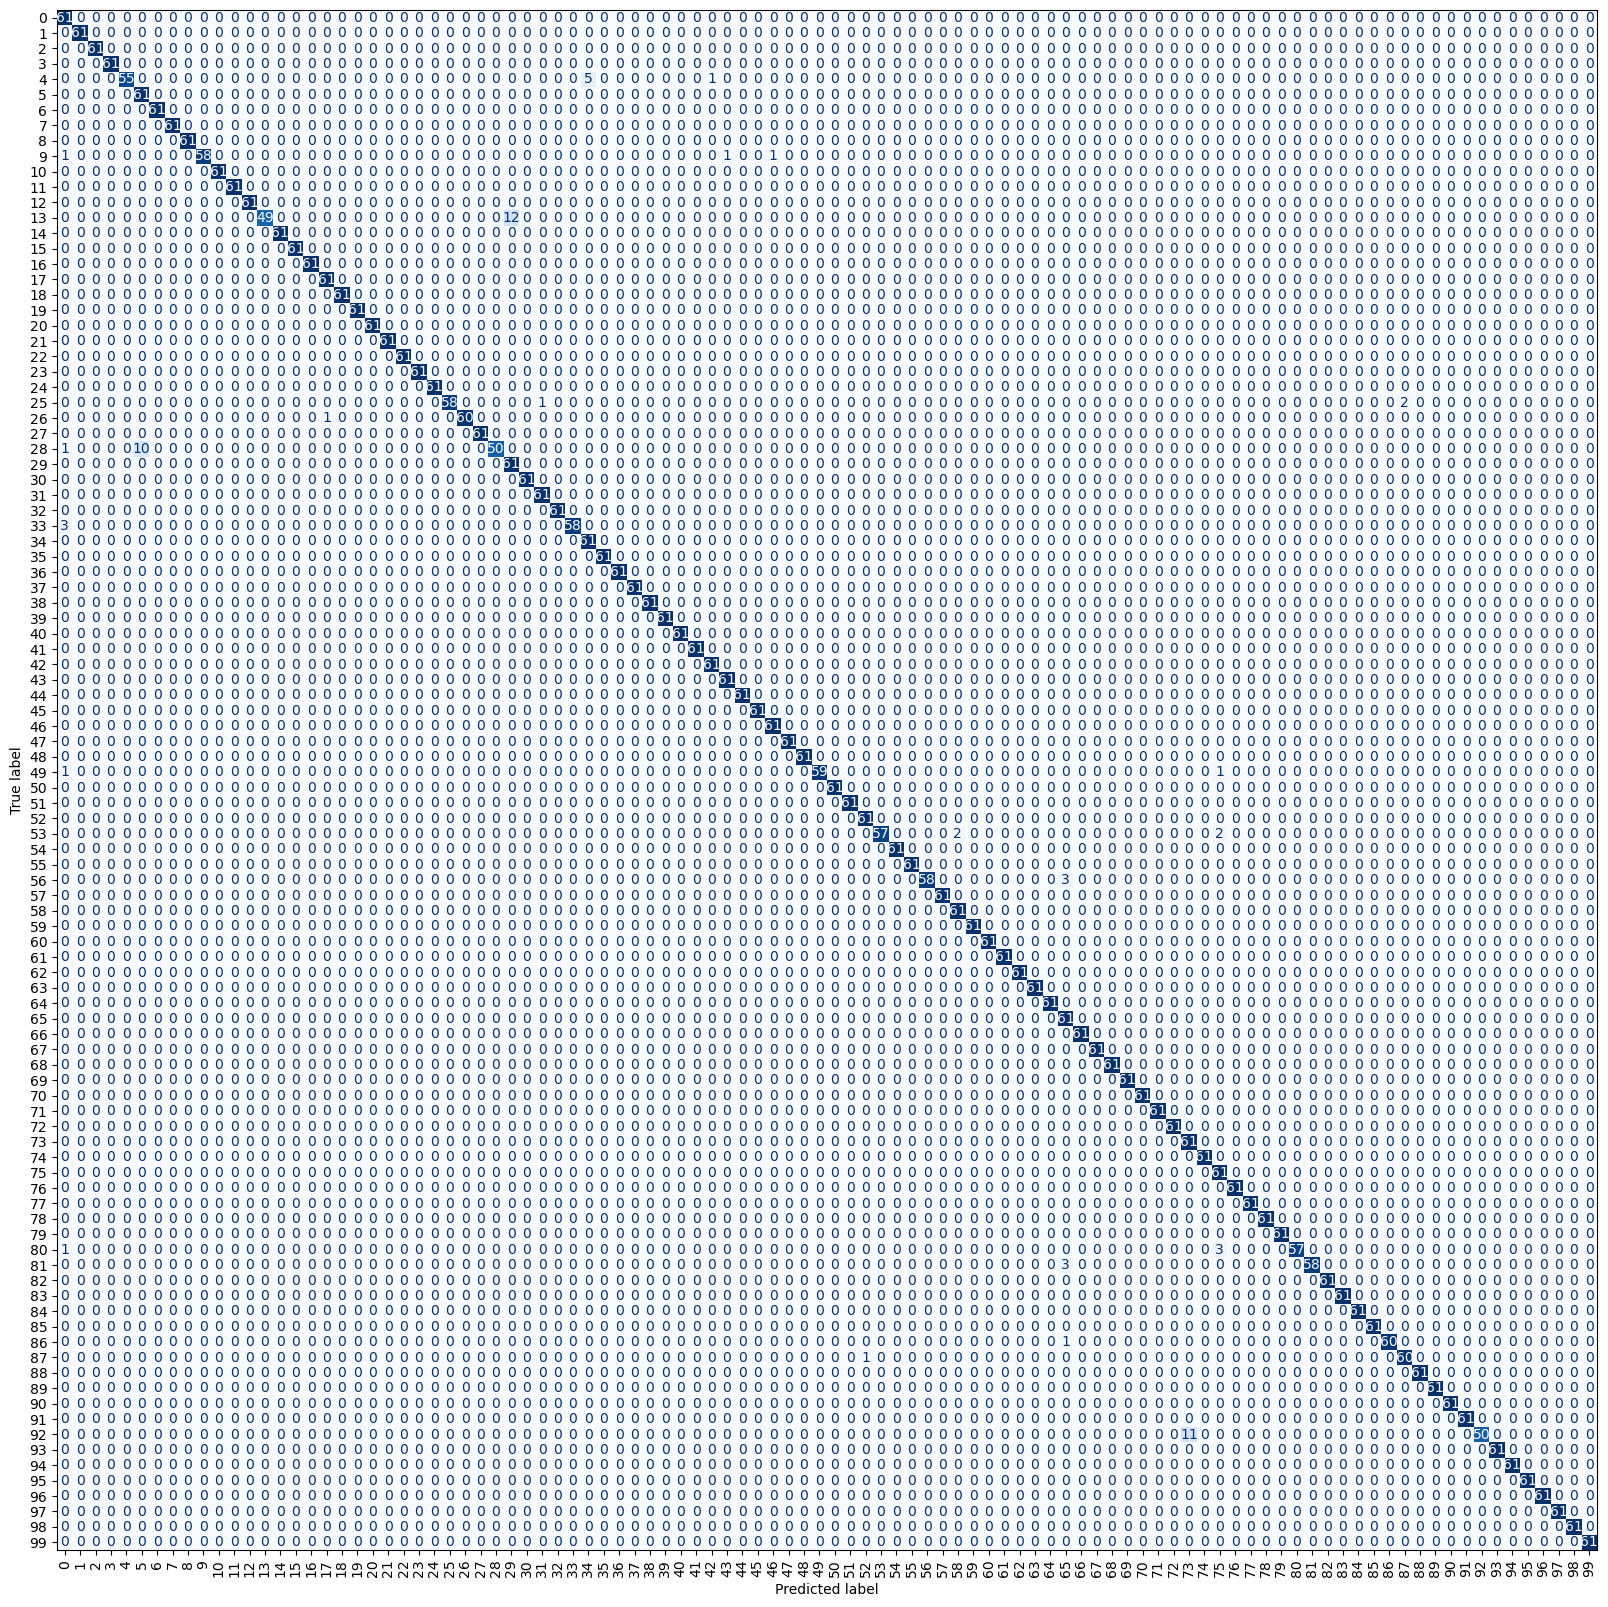

In [42]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

# Ustawienie rozmiaru figury
fig, ax = plt.subplots(figsize=(20, 20))

# Wyświetlanie macierzy pomyłek bez paska kolorów
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax, colorbar=False)  # Wyłączenie color bar

# Obrót etykiet na osi X o 90 stopni
plt.xticks(rotation=90)

plt.show()

Niestety, macierz pomyłek nie jest tak czytelna, jak w przypadku klasyfikacji dwustanowej, ale nadal możemy odczytać, które nagrania zostały błędnie sklasyfikowane oraz jako kto zostały rozpoznane. Na przykład, osoba z ID 28 została przez pomyłkę zaklasyfikowana jako osoba o ID 5 aż 10 razy oraz raz jako osoba o ID 0.

### Testowanie modelu na nagraniach o długości 2 sekund.

Użyję zapisanych zbiorów danych. Fragment kodu, w którym je zapisywałem, nie nie ma go w raporcie, ponieważ został zapisany we wcześniejszej wersji raportu.

In [23]:
#wczytuję dane
with open('test_data_man.pkl', 'rb') as file:
    test_data_man = pickle.load(file)

with open('test_data_woman.pkl', 'rb') as file:
    test_data_woman = pickle.load(file)

test_data = test_data_man + test_data_woman

In [24]:
one_long_record = []

for i in range(0, 100):
    one_long_record.append(np.concatenate(test_data[i]))

del test_data

Ze względu na to, że wczytane nagrania były już podzielone na pięciosekundowe fragmenty, łączę je z powrotem w jedno długie nagranie.

In [8]:
def divides_into_parts(signal, sec):
    list_for_parts = []
    len_of_signal = len(signal)
    step = sec*16000    #16000 bo z taką częstotliwością próbkowałem
    for i in np.arange(start=0, stop=len_of_signal-step, step=step):
        list_for_parts.append(signal[i:i+step].tolist())

    return list_for_parts


Powyższa funkcja dzieli nagranie na krótkie fragmenty o takiej długości, jaką zadeklarujemy.

In [9]:
divided_data = []

for i in range(0, 100):
    divided_data.append(divides_into_parts(signal=one_long_record[i], sec=2))
    
    print(i)
    clear_output(wait=True)

99


Dzielimy jedno długie nagranie na krótkie, 2-sekundowe fragmenty.

In [14]:
#Liczba współczynników, które otrzymamy po przeprowadzeniu MFCC — ta ilość współczynników powstaje w wyniku DCT (dyskretnej transformacji kosinusowej)
quantity_of_mel_coef = 13
#Liczba filtrów melowych — ilość 'czapek', które zostaną nałożone na sygnał. Dla każdego z nich będzie sumowana energia
quantity_of_mel_filters = 26

mfcc_test = []

#w pętli liczę współczynniki MFCC dla zestawów treningowych i testowych
for i in range(0, 100):
    
    records_test_mfcc = []
    for j in range(0, len(divided_data[i])):
        mfcc_signal = librosa.feature.mfcc(y=np.array(divided_data[i][j]), sr=16000, n_mfcc=quantity_of_mel_coef, n_mels = quantity_of_mel_filters).T
        records_test_mfcc.append(mfcc_signal)
    mfcc_test.append(records_test_mfcc)

    print(i)
    clear_output(wait=True)

del divided_data

99


Liczę współczynniki MFCC dla fragmentów nagrań.

In [20]:
with open('best_woman_models.pkl', 'rb') as file:
    best_woman_models = pickle.load(file)

with open('best_man_models.pkl', 'rb') as file:
    best_man_models = pickle.load(file)

best_models = best_man_models + best_woman_models

In [21]:
list_for_each_person = []
y_true = []

for i in range(0,len(best_models)):
    quantity_of_test_records = len(mfcc_test[i])
    list_for_each_record = []
    
    for j in range(0,quantity_of_test_records):
        one_record = pd.DataFrame(mfcc_test[i][j])
        
        scores = []

        for h in range(0,len(best_models)):
            scores.append(best_models[h].score(one_record))
        list_for_each_record.append(np.argmax(scores))
        y_true.append(i)

    list_for_each_person.append(list_for_each_record)
        

    print(i)
    clear_output(wait=True)

99


In [22]:
y_pred = np.concatenate(list_for_each_person)
balaned_accuracy = balanced_accuracy_score(y_true, y_pred)
print('Balanced accuracy jest równe: ' + str(balaned_accuracy))

Balanced accuracy jest równe: 0.965986842105263


Widzimy, że nagrania o długości 2 sekund są gorzej klasyfikowane niż te o długości 5 sekund.

### Testowanie modelu na nagraniach o długości 1 sekundy.

In [25]:
divided_data = []

for i in range(0, 100):
    divided_data.append(divides_into_parts(signal=one_long_record[i], sec=1))
    
    print(i)
    clear_output(wait=True)

99


Tym razem dzielę nagranie na fragmenty o długości jednej sekundy.

In [26]:
#Liczba współczynników, które otrzymamy po przeprowadzeniu MFCC — ta ilość współczynników powstaje w wyniku DCT (dyskretnej transformacji kosinusowej)
quantity_of_mel_coef = 13
#Liczba filtrów melowych — ilość 'czapek', które zostaną nałożone na sygnał. Dla każdego z nich będzie sumowana energia
quantity_of_mel_filters = 26

mfcc_test = []

#w pętli liczę współczynniki MFCC dla zestawów treningowych i testowych
for i in range(0, 100):
    
    records_test_mfcc = []
    for j in range(0, len(divided_data[i])):
        mfcc_signal = librosa.feature.mfcc(y=np.array(divided_data[i][j]), sr=16000, n_mfcc=quantity_of_mel_coef, n_mels = quantity_of_mel_filters).T
        records_test_mfcc.append(mfcc_signal)
    mfcc_test.append(records_test_mfcc)

    print(i)
    clear_output(wait=True)

del divided_data

99


In [27]:
list_for_each_person = []
y_true = []

for i in range(0,len(best_models)):
    quantity_of_test_records = len(mfcc_test[i])
    list_for_each_record = []
    
    for j in range(0,quantity_of_test_records):
        one_record = pd.DataFrame(mfcc_test[i][j])
        
        scores = []

        for h in range(0,len(best_models)):
            scores.append(best_models[h].score(one_record))
        list_for_each_record.append(np.argmax(scores))
        y_true.append(i)

    list_for_each_person.append(list_for_each_record)
        

    print(i)
    clear_output(wait=True)

99


In [28]:
y_pred = np.concatenate(list_for_each_person)
balaned_accuracy = balanced_accuracy_score(y_true, y_pred)
print('Balanced accuracy jest równe: ' + str(balaned_accuracy))

Balanced accuracy jest równe: 0.9310526315789472


W przypadku nagrań o długości jeden sekundy wynik znacznie się pogarsza. Można wyciągnąć wniosek, że im dłuższe jest nagranie, tym większa jest szansa, że zostanie poprawnie zaklasyfikowane.

Podsumowując, najlepszy model wybrałem, wykorzystując GridSearchCV. Na podstawie log-prawdopodobieństw dla każdego zestawu hiperparametrów znalazłem optymalny model i zastosowałem go w modelach, których wyniki przedstawiłem powyżej. Z raportu można również wyciągnąć wniosek, że im dłuższe jest nagranie testowe, tym większa jest szansa, że zostanie poprawnie zaklasyfikowane.